# Idealized diurnal cycle

This notebook runs [GOTM](https://gotm.net/) with idealized diurnal heating, where the solar radiation $F_s$ is
$$
F_s(t) = F_0 \max\left\{\cos\left[2\pi\left(\frac{t}{86400}-0.5\right)\right], 0\right\},
$$
where $F_0$ is the maximum solar radiation (W m$^{-2}$) at noon and $t$ is the time of a day (s).

In [1]:
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("/scratch/ds2/ab2462/KPP/gotmtool")
from gotmtool import *

In [2]:
def diurnal_cycle_factor(time):
    """Get the factor of an idealized diurnal cycle (0, 1) following
       f = max(cos(2*pi(t-0.5)), 0.)

    :time:   (datetime like) time
    :return: (numpy.array) diurnal cycle factor

    """
    tod = (3600.*time.hour+60.*time.minute+time.second)/86400.
    return np.maximum(np.cos(2.*np.pi*(tod-0.5)), 0.0)

## Create a model
Create a model with environment file `../../.gotm_env.yaml`, which is created by `gotm_env_init.py`. 

In [4]:
m = Model(name='Idealized_diurnal_cycle', environ='/scratch/ds2/ab2462/KPP/gotmtool/.gotm_env.yaml')

Take a look at what are defined in the environment file.

In [5]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /scratch/ds2/ab2462/KPP/gotm/code
   gotmdir_data: /scratch/ds2/ab2462/KPP/gotm/data
  gotmdir_build: /scratch/ds2/ab2462/KPP/gotm/build
    gotmdir_exe: /scratch/ds2/ab2462/KPP/gotm/exe
    gotmdir_run: /scratch/ds2/ab2462/KPP/gotm/run
 gotmdir_figure: /scratch/ds2/ab2462/KPP/gotm/figure
   gotmdir_tool: /scratch/ds2/ab2462/KPP/gotmtool


## Build the model

In [6]:
%%time
m.build()

CPU times: user 10.1 ms, sys: 12 ms, total: 22.1 ms
Wall time: 380 ms


## Configuration
Initialize the GOTM configuration

In [7]:
cfg = m.init_config()

 ------------------------------------------------------------------------
 GOTM started on 2025/06/04 at 05:18:36
 ------------------------------------------------------------------------
    initialize_gotm
 ------------------------------------------------------------------------
        Configuration file gotm.yaml not found. Using default settings.
        configuring modules ....
    init_airsea_yaml
        done
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
    init_cvmix_yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
    init_density()
            rho0=     1027.0000000000000     
        done.
 Your configuration has been written to /scratch/ds2/ab2462/KPP/gotm/run/Idealized_diurnal_cycle/gotm.yaml.
STOP 0


Generating default configuration at '/scratch/ds2/ab2462/KPP/gotm/run/Idealized_diurnal_cycle/gotm.yaml'...
Done!


Update the configuration

In [8]:
# setup
title = 'Idealized diurnal cycle'
nlev = 80
cfg['title'] = title
cfg['location']['name'] = 'Idealized'
cfg['location']['latitude'] = 45.0
cfg['location']['longitude'] = 0.0
cfg['location']['depth'] = 102.4
cfg['time']['start'] = '2000-01-01 00:00:00'
cfg['time']['stop']  = '2000-01-03 00:00:00'
cfg['time']['dt']    = 600.0
cfg['grid']['nlev']  = nlev

# output
cfg['output'] = {}
cfg['output']['gotm_out'] = {}
cfg['output']['gotm_out']['use'] = True
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'dt'
cfg['output']['gotm_out']['time_step'] = 3
cfg['output']['gotm_out']['variables'] = [{}]
cfg['output']['gotm_out']['variables'][0]['source'] = '*'

# forcing
datadir = m.environ['gotmdir_data']+'/examples/Idealized_diurnal_cycle'
cfg['temperature']['method'] = 'file'
cfg['temperature']['file'] = datadir+'/t_prof.dat'
cfg['salinity']['method'] = 'file'
cfg['salinity']['file'] = datadir+'/s_prof.dat'
cfg['surface']['fluxes']['heat']['method'] = 'constant'
cfg['surface']['fluxes']['heat']['constant_value'] = -159.15
cfg['surface']['fluxes']['tx']['method'] = 'constant'
cfg['surface']['fluxes']['tx']['constant_value'] = 0.1
cfg['surface']['fluxes']['ty']['method'] = 'constant'
cfg['surface']['fluxes']['ty']['constant_value'] = 0.0
cfg['surface']['swr']['method'] = 'file'
cfg['surface']['swr']['file'] = 'swr.dat'
cfg['surface']['precip']['method'] = 'constant'
cfg['waves']['stokes_drift']['us']['method'] = 'off'
cfg['waves']['stokes_drift']['vs']['method'] = 'off'

# EOS -- use linear
cfg['equation_of_state']['method'] = 'linear_custom'
cfg['equation_of_state']['linear']['T0'] = 20.0
cfg['equation_of_state']['linear']['S0'] = 35.0
cfg['equation_of_state']['linear']['alpha'] = 2e-4
cfg['equation_of_state']['linear']['beta'] = 8e-4
cfg['equation_of_state']['rho0'] = 1000.0

# water type (Jerlov IB)
cfg['light_extinction']['method'] = 'jerlov-ib'

In [9]:
# solar radiation
F0 = 500.
time = pd.date_range(cfg['time']['start'], cfg['time']['stop'], freq='30min')
factor = diurnal_cycle_factor(time)
swr = F0*factor

We want to run the case using two turbulence closure methods:
- The generic length scale (GLS; [Umlauf and Burchard, 2003](https://doi.org/10.1357/002224003322005087)) model in the $k$-$\epsilon$ formulation with the weak-equilibrium stability function by [Canuto et al., 2001](https://doi.org/10.1175/1520-0485(2001)031%3C1413:OTPIOP%3E2.0.CO;2) (C01A).
- The K-profile parameterization (KPP; [Large et al., 1994](https://doi.org/10.1029/94RG01872), [Griffies et al., 2015](https://github.com/CVMix/CVMix-description/raw/master/cvmix.pdf)) with [CVMix](http://cvmix.github.io).


In [10]:
# collect the configurations and the labels of the two runs
cfgs = []
labels = []

In [11]:
cfg['turbulence']['turb_method'] = 'second_order'
cfg['turbulence']['tke_method'] = 'tke'
cfg['turbulence']['len_scale_method'] = 'gls'
cfg['turbulence']['scnd']['method'] =  'weak_eq_kb_eq'
cfg['turbulence']['scnd']['scnd_coeff'] =  'canuto-a'
cfg['turbulence']['turb_param']['length_lim'] = 'false'
cfg['turbulence']['turb_param']['compute_c3'] = 'true'
cfg['turbulence']['turb_param']['Ri_st'] = 0.25
cfg['turbulence']['generic']['gen_m'] = 1.5 
cfg['turbulence']['generic']['gen_n'] = -1.0
cfg['turbulence']['generic']['gen_p'] = 3.0 
cfg['turbulence']['generic']['cpsi1'] = 1.44
cfg['turbulence']['generic']['cpsi2'] = 1.92
cfg['turbulence']['generic']['cpsi3minus'] = -0.63
cfg['turbulence']['generic']['cpsi3plus'] = 1.0 
cfg['turbulence']['generic']['sig_kpsi'] = 1.0 
cfg['turbulence']['generic']['sig_psi'] = 1.3
cfgs.append(copy.deepcopy(cfg))
labels.append('GLS-C01A')

In [12]:
cfg['turbulence']['turb_method'] = 'cvmix'
cfg['cvmix']['surface_layer']['kpp']['langmuir_method'] = 'none'
cfgs.append(copy.deepcopy(cfg))
labels.append('KPP-CVMix')

KeyError: 'kpp'

In [13]:
# save solar radiation file
for lb in labels:
    run_dir = m.environ['gotmdir_run']+'/'+m.name+'/'+lb
    os.makedirs(run_dir, exist_ok=True)
    dat_dump_ts(time, [swr], run_dir+'/swr.dat')

## Run the model

In [17]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=1)

CPU times: user 0 ns, sys: 24.8 ms, total: 24.8 ms
Wall time: 286 ms


In [18]:
sims

## Results

Load the data into an `xarray.Dataset`.

IndexError: list index out of range

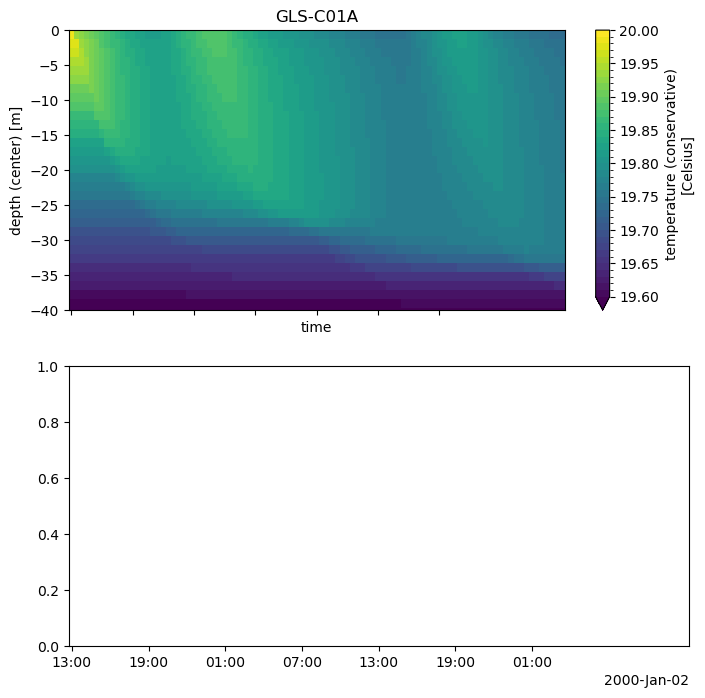

In [19]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(8, 8)
data0 = sims[0].load_data()
levels = np.linspace(19.6, 20, 41)
data0.temp.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
axarr[0].set_ylim([-40, 0])
data1 = sims[1].load_data()
data1.temp.plot(ax=axarr[1], levels=levels)
axarr[1].set_title(labels[1])
axarr[1].set_ylim([-40, 0])